# Методы PEFT

Можно почитать [обзоры от huggingface](https://huggingface.co/docs/peft/index)

Проблема: Почему мы не можем просто дообучить GPT-3 или LLaMA под свою задачу?

* Огромное количество параметров (миллиарды).
* Требуются колоссальные вычислительные ресурсы и время.
* Риск "катастрофического забывания" (модель забывает свои общие знания).

Решение: **PEFT** (Parameter-Efficient Fine-Tuning) — методы, которые позволяют настраивать лишь небольшое количество параметров модели, сохраняя при этом или даже улучшая её производительность на целевом задании.

# Вспомним Transformer

Ниже приведено устройство архитектуры «трансформер» из оригинальной [статьи](https://arxiv.org/pdf/1706.03762):

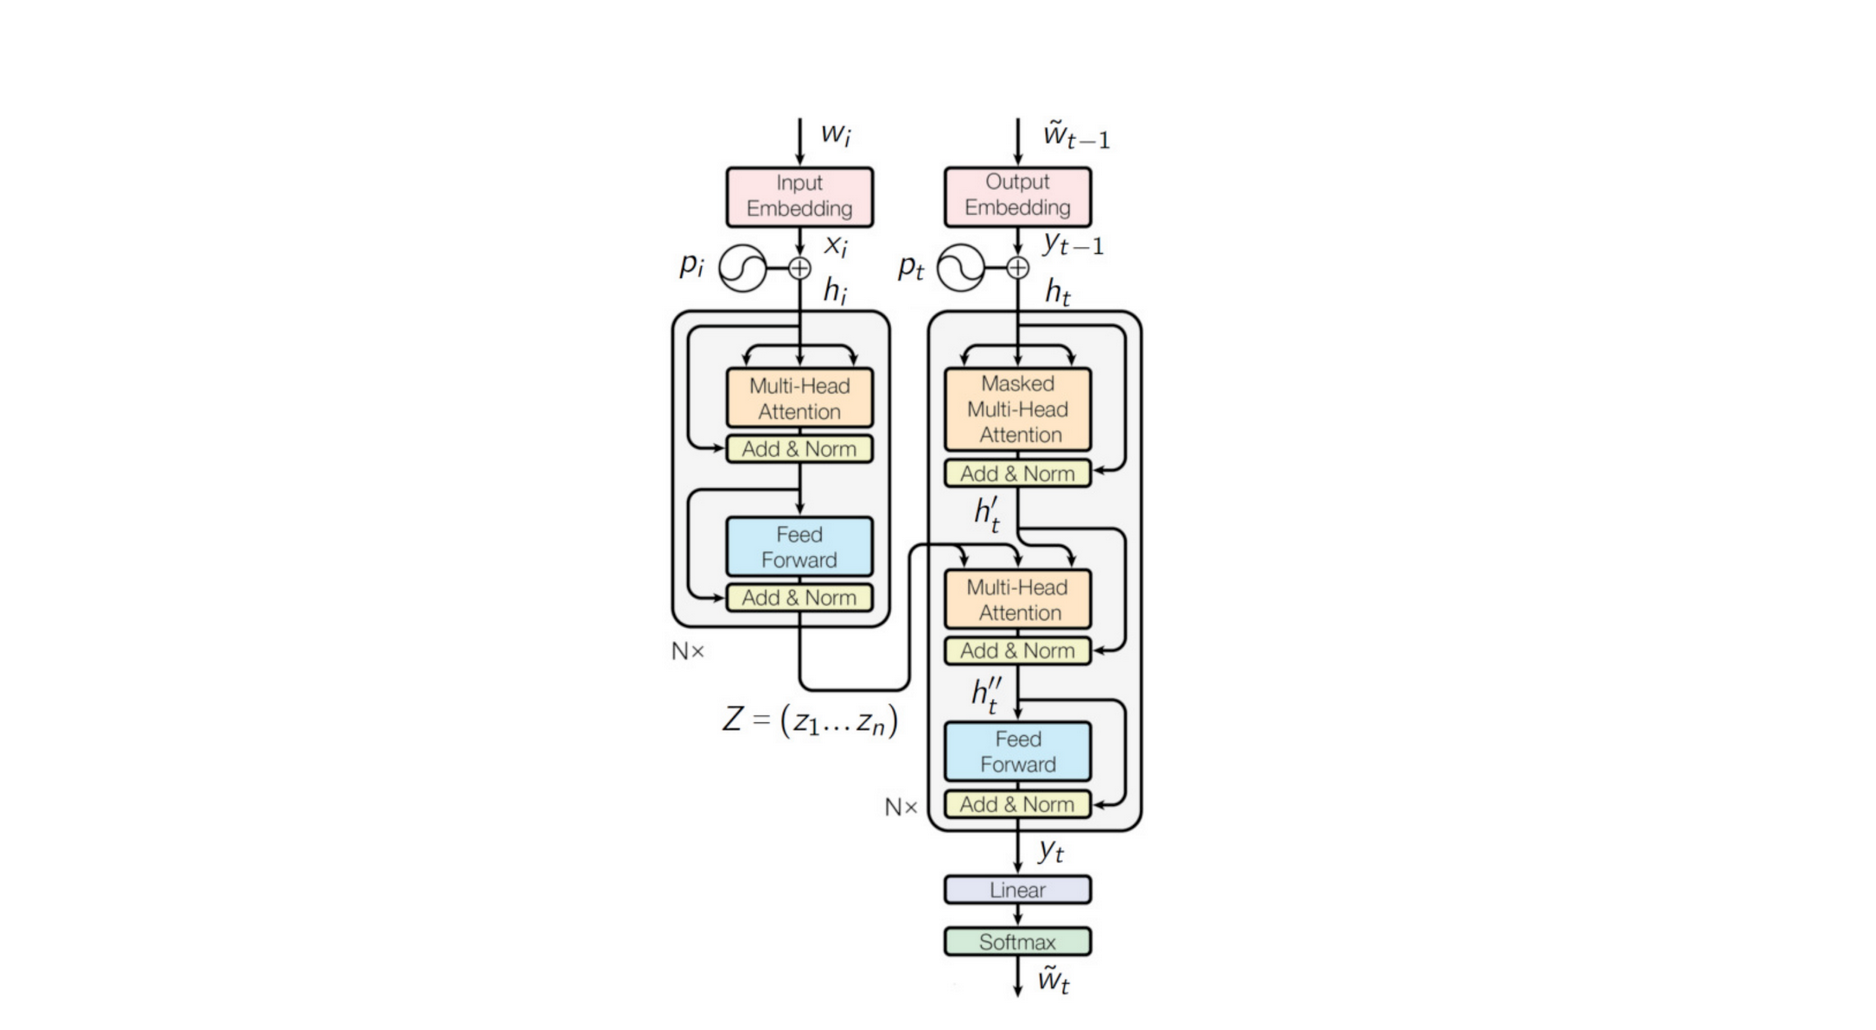

Сегодня обратим особенное *внимание* на Transformer Decoder. (Кстати, где он на рисунке?)

Ключевой принцип работы Декодеровщика - предсказание следующего токена на основе предыдущих.

Так работают GPT всех версий, LLaMA, BLOOM, T5 (в режиме генерации).

Декодировщик трансформера, может быть очень большим: от 1B до 175B параметров

В качестве входного токенизатора использовали BPE, но только на бинарных символах Unicode

Начиная с GPT-2 декодировщики могли генерировать более-менее связный текст и **решать новые задачи без дополнительного дообучения**.

Так появились **большие языковые модели (Large Language Models, LLM)**. А нас стало интересовать, как и насколько хорошо их знания переносятся на новые задачи

# Основные методы PEFT

## 1. Промптинг (Prompting) — "Нулевой" тонкой настройки

Нужео сформулировать задачу так, чтобы модель поняла её без обновления весов.

Виды промптинга:

1. Zero-Shot Learning - модель пишет ответ только на основании задания, написанного на естественном языке или оформленного в JSON или другой вспомогательный формат

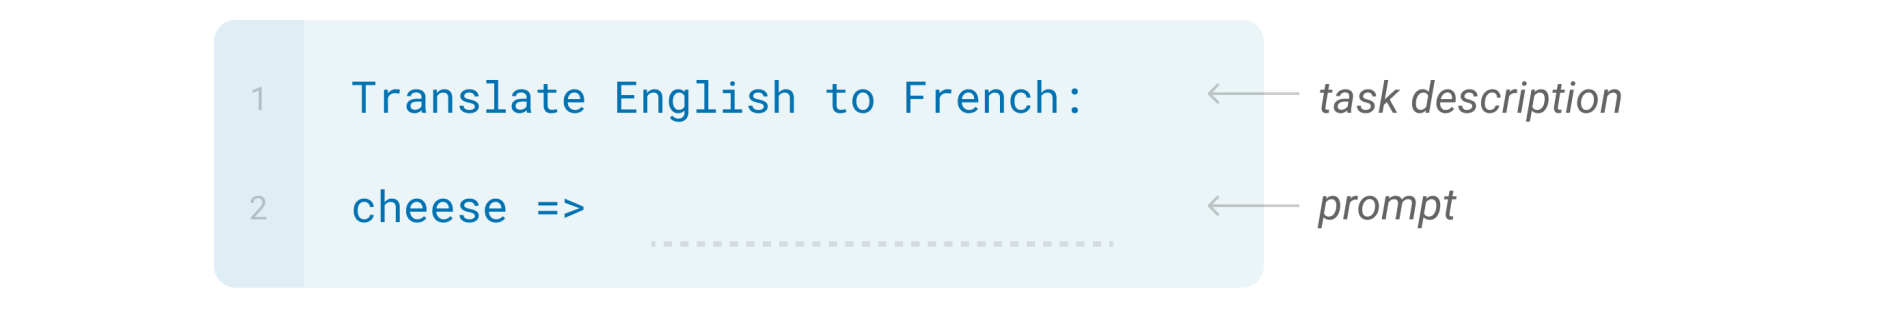

2. One-Shot - вдобавок к самому заданию модель видит один из примеров решения

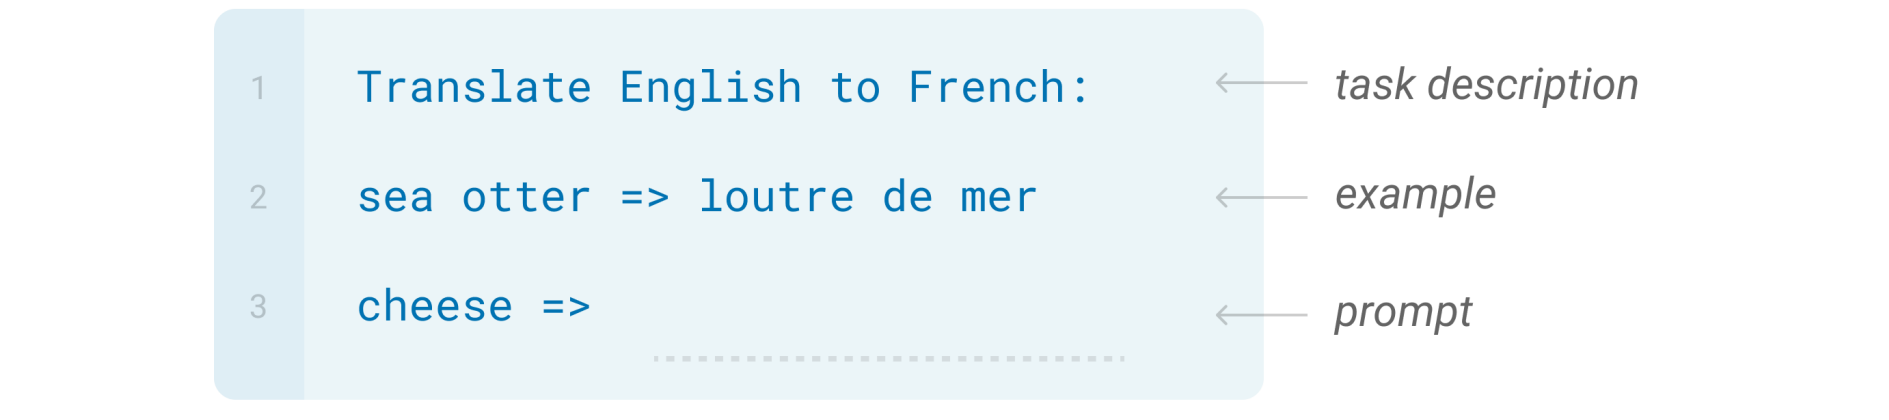

3. Few-Shot - модель видит несколько примеров решения

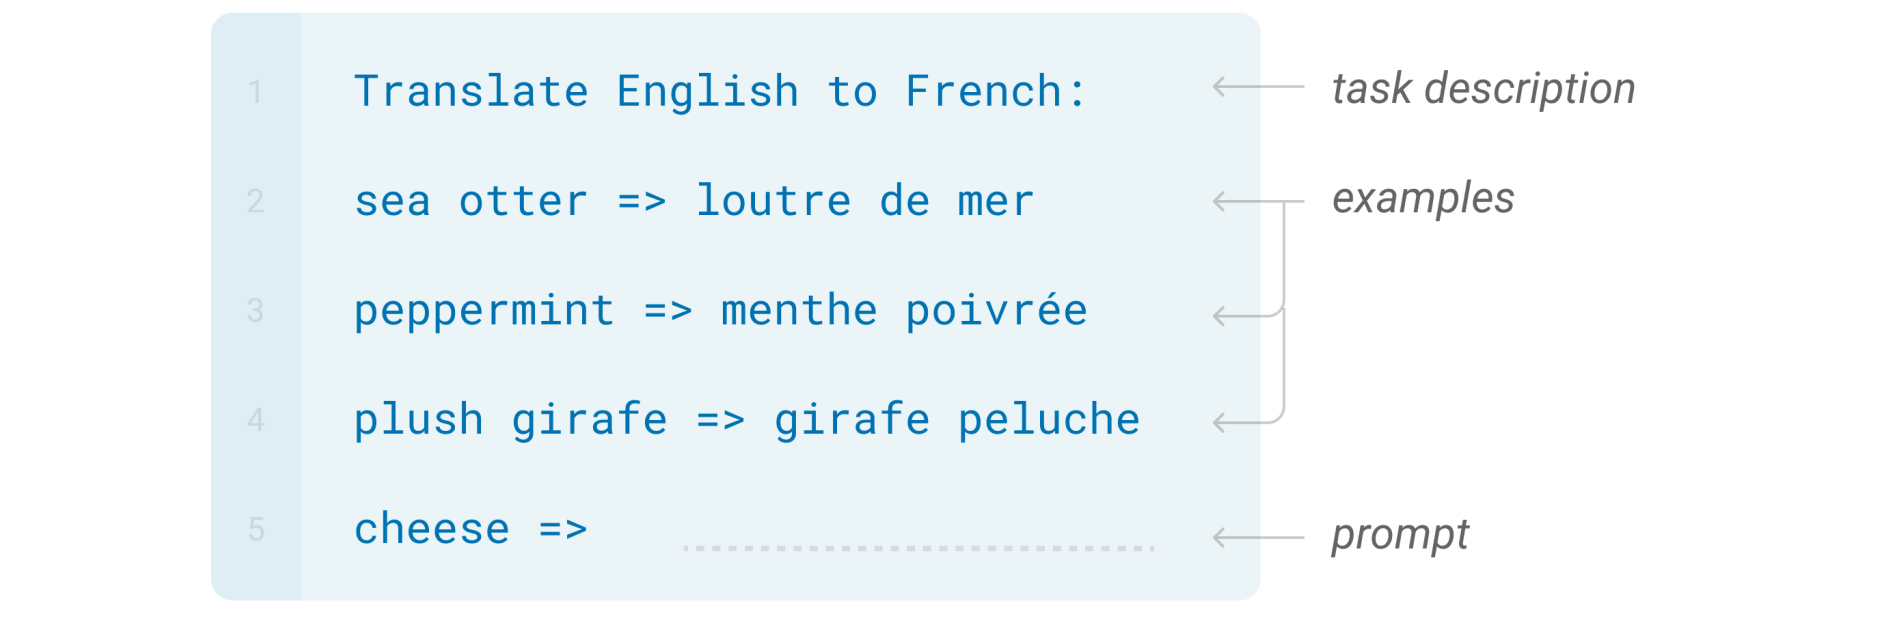

Кроме способности к Zero-Shot / Few-Shot работа модели также опеределяется:
1. Затратами на обучение: насколько эффективную модель можно обучить при фиксированных ресурсах на обучение
2. Эффективность инференса: насколько умную модель можно обучить при фиксированных ресурсах на инференс

**Плюсы** Prompting: Простота, не требует вычислений.

**Минусы** Prompting: Низкая и непредсказуемая производительность на сложных задачах, ограничение длиной контекста.

## Промпт-тюнинг (Prompt-Tuning) — Обучение "виртуальных токенов"

Вместо ручного подбора промпта, мы обучаем непрерывное представление промпта.

В начало входной последовательности добавляются "виртуальные" (псевдо-) токены.

Их эмбеддинги (векторные представления) — это не фиксированные вектора из словаря, а обучаемые параметры.

Во время тонкой настройки замораживаются все веса исходной модели, а обновляются только эмбеддинги этих виртуальных токенов.

Модель учится, какие "сигналы" в виде этих непрерывных векторов лучше всего настраивают её на целевую задачу.


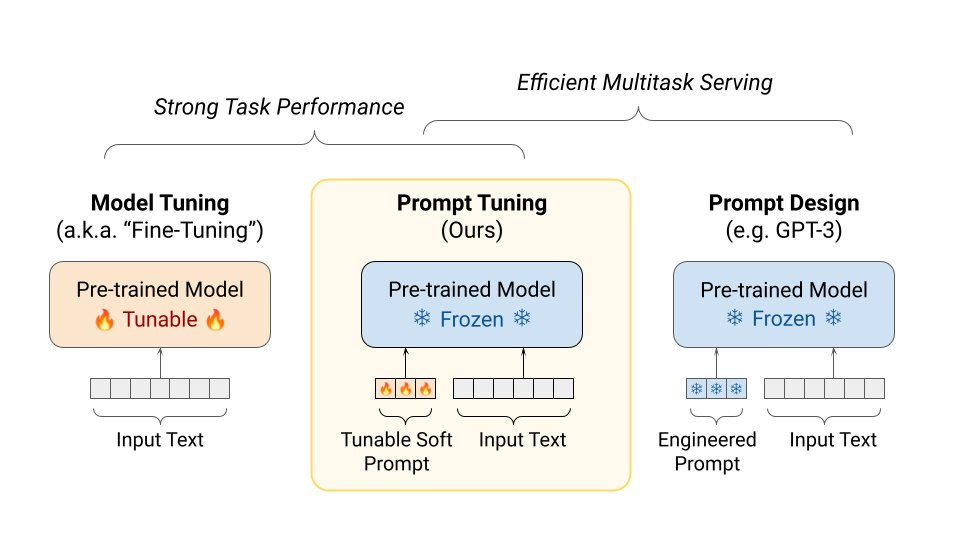

**Плюсы** Prompt-Tuning: Чрезвычайно эффективно по параметрам (добавляются тысячи, а не миллиарды параметров).

**Минусы** Prompt-Tuning: Может уступать в точности более мощным методам PEFT.

## Тюнинг адаптеров (Adapter Tuning)

Встраивание небольших дополнительных слоев (адаптеров) внутрь трансформера.

Рассмотрим Houlsby Adapter:

1. После каждого блока `Feed-Forward` и `Attention` в трансформере добавляется маленькая последовательность слоев (обычно: down-projection -> нелинейность -> up-projection).
2. Замораживаются все веса исходной модели.
3. Обучаются только параметры этих адаптеров.
4. Адаптер принимает вход, проецирует его в пространство меньшей размерности (bottleneck), а затем обратно в исходную размерность. Результат добавляется к исходному выходу блока.


Стоит упомянуть LoRA как родственный и очень популярный метод. Вместо добавления слоев, LoRA добавляет низкоранговые матрицы к весам Attention-слоев.

Позднее в этом семинаре мы подробно рассмотрим LoRA.

**Плюсы** Adapter Tuning: Очень высокая производительность, близкая к полной тонкой настройке.

**Минусы** Adapter Tuning: Добавляет небольшую задержку при инференсе, так как добавляются новые слои.

# Практика

В этот раз попробуем дообучить авторегрессионную модель (например, ruGPT-3 или Ru Llama) для выдачи класса на знакомом нам датасете `Sib200`.

## Установка зависимостей

Для работы нам понадобятся библиотеки `transformers`, `datasets`, `accelerate` и **`peft`** от Hugging Face, а также `torch`.

In [ ]:
!pip install -q transformers datasets accelerate peft

In [ ]:
import torch
from transformers import (
    AutoModelForCausalLM, # Для авторегрессионных моделей
    AutoTokenizer,
    TrainingArguments,
    Trainer,
    DataCollatorForLanguageModeling
)
from peft import (
    get_peft_model,
    PromptTuningConfig,
    TaskType,
    PeftModel
)
from datasets import Dataset, load_dataset
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
import random

## Загрузка модели и токенизатора
В качестве базовой модели возьмем относительно небольшую модель, например, [`ai-forever/rugpt3small_based_on_gpt2`](https://huggingface.co/ai-forever/rugpt3small_based_on_gpt2).

In [ ]:
model_name = "ai-forever/rugpt3small_based_on_gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

# Важно! Для промпт-тюнинга у токенизатора должен быть установлен pad_token.
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# Переводим модель в режим обучения
model.train()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50264, 768)
    (wpe): Embedding(2048, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50264, bias=False)
)

## Загрузка данных

In [ ]:
DATASET_NAME = 'Davlan/sib200'
DATASET_LANGUAGE = 'rus_Cyrl'

train_set = load_dataset(DATASET_NAME, DATASET_LANGUAGE, split='train')
validation_set = load_dataset(DATASET_NAME, DATASET_LANGUAGE, split='validation')
test_set = load_dataset(DATASET_NAME, DATASET_LANGUAGE, split='test')

print(f"Размер тренировочного набора: {len(train_set)}")
print(f"Размер валидационного набора: {len(validation_set)}")
print(f"Размер тестового набора: {len(test_set)}")
print("\nПример из датасета:")
print(train_set[0])

README.md: 0.00B [00:00, ?B/s]

train.tsv: 0.00B [00:00, ?B/s]

dev.tsv: 0.00B [00:00, ?B/s]

test.tsv: 0.00B [00:00, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Размер тренировочного набора: 701
Размер валидационного набора: 99
Размер тестового набора: 204

Пример из датасета:
{'index_id': 431, 'category': 'geography', 'text': 'Турция с трёх сторон окружена морями: на западе — Эгейским, на севере — Чёрным и на юге — Средиземным.'}


In [ ]:
list_of_categories = sorted(list(
    set(train_set['category']) | set(validation_set['category']) | set(test_set['category'])
))
indices_of_categories = list(range(len(list_of_categories)))
n_categories = len(list_of_categories)

print(f'Количество категорий: {n_categories}')
print(f'Категории для классификации: {list_of_categories}')

id2label = dict(zip(indices_of_categories, list_of_categories))
label2id = dict(zip(list_of_categories, indices_of_categories))

print("\nМаппинг категорий:")
for category, idx in label2id.items():
    print(f"  {category} -> {idx}")

Количество категорий: 7
Категории для классификации: ['entertainment', 'geography', 'health', 'politics', 'science/technology', 'sports', 'travel']

Маппинг категорий:
  entertainment -> 0
  geography -> 1
  health -> 2
  politics -> 3
  science/technology -> 4
  sports -> 5
  travel -> 6


## Токенизация

In [ ]:
MINIBATCH_SIZE = 64

tokenized_train_set = train_set.map(
    lambda it: tokenizer(it['text'], truncation=True, max_length=256),
    batched=True, batch_size=MINIBATCH_SIZE
)
tokenized_validation_set = validation_set.map(
    lambda it: tokenizer(it['text'], truncation=True, max_length=256),
    batched=True, batch_size=MINIBATCH_SIZE
)

labeled_train_set = tokenized_train_set.add_column(
    'label',
    [label2id[val] for val in tokenized_train_set['category']]
)
labeled_validation_set = tokenized_validation_set.add_column(
    'label',
    [label2id[val] for val in tokenized_validation_set['category']]
)

print(f"Пример токенизированных данных: {tokenized_train_set[0]['input_ids'][:20]}...")
print(f"Метка: {labeled_train_set[0]['label']} ({id2label[labeled_train_set[0]['label']]})")

Map:   0%|          | 0/701 [00:00<?, ? examples/s]

Map:   0%|          | 0/99 [00:00<?, ? examples/s]

Пример токенизированных данных: [34058, 783, 281, 10452, 4546, 5545, 798, 1948, 2608, 30, 309, 23000, 510, 625, 3608, 1703, 16, 309, 15934, 510]...
Метка: 1 (geography)


## Создание промптов для классификации

Преобразуем задачу классификации в текстовый формат для авторегрессионной модели

In [ ]:
def preprocess_function(examples):
    """Функция предобработки для классификации"""
    prompts = []
    labels = []

    for text, category in zip(examples['text'], examples['category']):
        prompt = f"Классифицируй текст: {text}\nКатегория:"
        prompts.append(prompt)
        labels.append(category)

    # Токенизируем промпты
    model_inputs = tokenizer(
        prompts,
        truncation=True,
        padding=True,
        max_length=256,
        return_tensors=None
    )

    # Токенизируем целевые метки отдельно
    target_outputs = tokenizer(
        labels,
        truncation=True,
        padding=True,
        max_length=10,
        return_tensors=None,
        add_special_tokens=False
    )

    # Создаем маски для вычисления loss
    # Обучаем модель предсказывать только категорию
    input_ids_with_labels = []
    attention_masks = []

    for i in range(len(prompts)):
        input_ids = model_inputs['input_ids'][i]
        target_ids = target_outputs['input_ids'][i]

        # промпт + категория
        full_input_ids = input_ids + target_ids + [tokenizer.eos_token_id]

        # маска внимания
        attention_mask = [1] * len(full_input_ids)

        # Создаем labels: -100 для промпта, настоящие id для категории
        labels_seq = [-100] * len(input_ids) + target_ids + [tokenizer.eos_token_id]

        while len(full_input_ids) < 256:
            full_input_ids.append(tokenizer.pad_token_id)
            attention_mask.append(0)
            labels_seq.append(-100)

        input_ids_with_labels.append(full_input_ids)
        attention_masks.append(attention_mask)

    return {
        'input_ids': input_ids_with_labels,
        'attention_mask': attention_masks,
        'labels': input_ids_with_labels  # Для causal LM labels = input_ids
    }

train_dataset_processed = train_set.map(
    preprocess_function,
    batched=True,
    batch_size=MINIBATCH_SIZE,
    remove_columns=train_set.column_names
)

validation_dataset_processed = validation_set.map(
    preprocess_function,
    batched=True,
    batch_size=MINIBATCH_SIZE,
    remove_columns=validation_set.column_names
)

print("Предобработка завершена!")
print(f"Размер тренировочного набора: {len(train_dataset_processed)}")
print(f"Размер валидационного набора: {len(validation_dataset_processed)}")
print("\nПример обработанных данных:")
print(f"Input IDs: {train_dataset_processed[0]['input_ids'][50:70]}...")
print(f"Attention Mask: {train_dataset_processed[0]['attention_mask'][50:70]}...")
print(f"Labels: {train_dataset_processed[0]['labels'][50:70]}...")

Map:   0%|          | 0/701 [00:00<?, ? examples/s]

Map:   0%|          | 0/99 [00:00<?, ? examples/s]

Предобработка завершена!
Размер тренировочного набора: 701
Размер валидационного набора: 99

Пример обработанных данных:
Input IDs: [10452, 4546, 5545, 798, 1948, 2608, 30, 309, 23000, 510, 625, 3608, 1703, 16, 309, 15934, 510, 28434, 536, 289]...
Attention Mask: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]...
Labels: [10452, 4546, 5545, 798, 1948, 2608, 30, 309, 23000, 510, 625, 3608, 1703, 16, 309, 15934, 510, 28434, 536, 289]...


In [ ]:
data_collator = DataCollatorForLanguageModeling( # collator для динамического добавления padding в батчах
    tokenizer=tokenizer,
    mlm=False,
)

## Настройка PEFT

In [ ]:
# Конфигурация для Prompt-Tuning
peft_config = PromptTuningConfig(
    task_type=TaskType.CAUSAL_LM,
    prompt_tuning_init_text="Классифицируй текст по одной из категорий: science/technology, travel, politics, sports, health, entertainment, geography.\n",
    num_virtual_tokens=10,  # Количество виртуальных токенов
)

peft_model = get_peft_model(model, peft_config)
peft_model.print_trainable_parameters()

print("\nАрхитектура обучаемых параметров:")
for name, param in peft_model.named_parameters():
    if param.requires_grad:
        print(f"  {name}: {param.shape}")

trainable params: 7,680 || all params: 125,239,296 || trainable%: 0.0061

Архитектура обучаемых параметров:
  prompt_encoder.default.embedding.weight: torch.Size([10, 768])


## Обучение только виртуальных токенов

Чем отличаются виртуальные токены от обычных, которые мы уже получали токенизатором?

Обычные токены действительно есть в словаре токенизатора:

In [ ]:
sample_text = "Классифицируй текст: Привет, о дивный новый мир!"
ordinary_tokens = tokenizer.tokenize(sample_text)

print("Токены из словаря (обычные):")
for i, token in enumerate(ordinary_tokens[:10]):
    token_id = tokenizer.convert_tokens_to_ids(token)
    print(f"  {i+1:2d}. '{tokenizer.decode(token_id)}' -> ID: {token_id}")

print(f"\nВсего обычных токенов в словаре: {len(tokenizer)}")

Токены из словаря (обычные):
   1. 'К' -> ID: 684
   2. 'ласси' -> ID: 25702
   3. 'фици' -> ID: 4646
   4. 'руй' -> ID: 28306
   5. ' текст' -> ID: 6529
   6. ':' -> ID: 30
   7. ' Привет' -> ID: 14239
   8. ',' -> ID: 16
   9. ' о' -> ID: 290
  10. ' див' -> ID: 23307

Всего обычных токенов в словаре: 50257


При этом каждый токен имеет фиксированное векторное представление в embedding слое модели.

**Виртуальные токены** (псевдо-токены):
- НЕ существуют в словаре токенизатора
- НЕ имеют фиксированного текстового представления
- Это обучаемые параметры (векторы) в embedding пространстве
- Добавляются в начало входной последовательности
- Модель учится, какие 'сигналы' лучше настраивают её на задачу

In [ ]:
embedding_layer = peft_model.get_input_embeddings()
print(f"Размерность embedding слоя: {embedding_layer.weight.shape}")
print(f"(словарь_размер, embedding_размерность)\n")

# Найдем виртуальные токены в модели
for name, module in peft_model.named_modules():
    if "prompt_encoder" in name:
        if hasattr(module, 'embedding'):
            virtual_tokens_embedding = module.embedding
            print(f"Размерность виртуальных токенов: {virtual_tokens_embedding.weight.shape}")
            print(f"(количество_виртуальных_токенов, embedding_размерность)")

Размерность embedding слоя: torch.Size([50264, 768])
(словарь_размер, embedding_размерность)

Размерность виртуальных токенов: torch.Size([10, 768])
(количество_виртуальных_токенов, embedding_размерность)


Процесс обучения

Виртуальные токены учатся создавать "внутренний контекст",
который направляет внимание модели на релевантные аспекты
входных данных для конкретной задачи, не меняя саму модель.

1. Forward pass:
   - Виртуальные токены конкатенируются с обычными эмбеддингами
   - [virtual_emb] + [ordinary_embs] = полный вход
2. Backward pass:
   - Градиенты вычисляются только для virtual_emb
   - Веса основной модели остаются неизменными
3. Результат:
   - Модель учится 'понимать' оптимальные сигналы для задачи"

In [ ]:
training_args = TrainingArguments(
    output_dir="./peft_sib200_fixed",
    overwrite_output_dir=True,
    num_train_epochs=3,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    eval_strategy="steps",
    eval_steps=100,
    logging_steps=50,
    save_steps=200,
    learning_rate=3e-2,  # Стоит ставить более высокий LR для prompt tuning
    report_to=None,
    remove_unused_columns=True,
    gradient_accumulation_steps=4,
    # load_best_model_at_end=True, # используем в полном пайплайне, когда есть прописанные блоки сохранения и оценки
    metric_for_best_model="eval_loss",
)

In [ ]:
trainer = Trainer(
    model=peft_model,
    args=training_args,
    train_dataset=train_dataset_processed,
    eval_dataset=validation_dataset_processed,
    data_collator=data_collator,
)

print("Начинаем обучение...")
print(f"Размер батча: {training_args.per_device_train_batch_size}")
print(f"Количество шагов на эпоху: {len(train_dataset_processed) // training_args.per_device_train_batch_size}")

trainer.train()
print("Обучение успешно завершено!")

trainer.save_model()
print("Модель сохранена")

Начинаем обучение...
Размер батча: 2
Количество шагов на эпоху: 350


`loss_type=None` was set in the config but it is unrecognized. Using the default loss: `ForCausalLMLoss`.


Step,Training Loss,Validation Loss
100,4.323300,3.874101
200,3.872000,3.500684


Step,Training Loss,Validation Loss
100,4.323300,3.874101
200,3.872000,3.500684


Обучение успешно завершено!
Модель сохранена


In [ ]:
# @title
training_args = TrainingArguments(
    output_dir="./peft_sib200_fixed",
    overwrite_output_dir=True,
    num_train_epochs=1,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    eval_strategy="steps",
    eval_steps=100,
    logging_steps=50,
    save_steps=200,
    learning_rate=5e-2,  # Стоит ставить более высокий LR для prompt tuning
    warmup_ratio=0.1,
    report_to=None,
    remove_unused_columns=True,
    gradient_accumulation_steps=4,
    # load_best_model_at_end=True, # используем в полном пайплайне, когда есть прописанные блоки сохранения и оценки
    metric_for_best_model="eval_loss",
)

In [ ]:
# @title
model.train()

trainer = Trainer(
    model=peft_model,
    args=training_args,
    train_dataset=train_dataset_processed,
    eval_dataset=validation_dataset_processed,
    data_collator=data_collator,
)

print("Начинаем обучение...")
print(f"Размер батча: {training_args.per_device_train_batch_size}")
print(f"Количество шагов на эпоху: {len(train_dataset_processed) // training_args.per_device_train_batch_size}")

trainer.train()
print("Обучение успешно завершено!")

trainer.save_model()
print("Модель сохранена")

Начинаем обучение...
Размер батча: 8
Количество шагов на эпоху: 87


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Step,Training Loss,Validation Loss


Обучение успешно завершено!
Модель сохранена


### Задание:

Добавьте сохранение чекпойнтов или весов модели

## Test

In [ ]:
model.eval()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50264, 768)
    (wpe): Embedding(2048, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50264, bias=False)
)

In [ ]:
def predict_category(text, model, tokenizer):
    prompt = f"Текст: {text}\nКатегория:"
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    model.eval()
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=3,
            do_sample=False,
            pad_token_id=tokenizer.eos_token_id,
            temperature=0.1,
            repetition_penalty=1.1
        )
        generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
        generated_category = generated_text[len(prompt):].strip().split('\n')[0]

    return generated_category

test_examples = [
    "В Москве прошли переговоры о международном сотрудничестве",
    "Футбольный матч завершился со счетом 2:1",
    "Новая выставка открылась в художественном музее",
    "Курс доллара вырос на бирже сегодня",
]

for example in test_examples:
    predicted = predict_category(example, peft_model, tokenizer)
    print(f"Текст: {example}")
    print(f"Предсказанная категория: '{predicted}'")
    print("---")

=== ТЕСТИРОВАНИЕ ОБУЧЕННОЙ МОДЕЛИ ===


/usr/local/lib/python3.12/dist-packages/peft/peft_model.py:2066: UserWarning: Position ids are not supported for parameter efficient tuning. Ignoring position ids.
  warnings.warn("Position ids are not supported for parameter efficient tuning. Ignoring position ids.")


Текст: В Москве прошли переговоры о международном сотрудничестве
Предсказанная категория: 'Политика, экономика'
---
Текст: Футбольный матч завершился со счетом 2:1
Предсказанная категория: 'Спорт, спорт'
---
Текст: Новая выставка открылась в художественном музее
Предсказанная категория: 'живопись, графика'
---
Текст: Курс доллара вырос на бирже сегодня
Предсказанная категория: 'Экономика, финан'
---


Сравним с моделью без обучения, то есть сравним Few-Shot и Zero-Shot

In [ ]:
base_model = AutoModelForCausalLM.from_pretrained(model_name)
base_model.eval()

test_indices = random.sample(range(len(validation_set)), 3)

print("=== БАЗОВАЯ МОДЕЛЬ (Zero-Shot) ===")
for idx in test_indices:
    example = validation_set[idx]
    prompt = f"Текст: {example['text']}\nОпредели категорию текста из вариантов: entertainment, geography, health, politics, science/technology, sports, travel"

    inputs = tokenizer(prompt, return_tensors="pt").to(base_model.device)

    with torch.no_grad():
        outputs = base_model.generate(
            **inputs,
            max_new_tokens=3,
            do_sample=False,
            pad_token_id=tokenizer.eos_token_id,
            temperature=0.7
        )
        generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

        # Извлекаем только сгенерированную часть (после промпта)
        generated_part = generated_text[len(prompt):].strip('.,; \n')

        print(f"Текст: {example['text'][:100]}...")
        print(f"Промпт: {prompt}")
        print(f"Истинная категория: {example['category']}")
        print(f"Предсказанная категория (Zero-Shot): '{generated_part}'")
        print("---")

=== БАЗОВАЯ МОДЕЛЬ (Zero-Shot) ===
Текст: Сплавы по существу представляют собой смесь двух или более металлов. Не забывайте, что в периодическ...
Промпт: Текст: Сплавы по существу представляют собой смесь двух или более металлов. Не забывайте, что в периодической таблице много элементов.
Определи категорию текста из вариантов: entertainment, geography, health, politics, science/technology, sports, travel
Истинная категория: science/technology
Предсказанная категория (Zero-Shot): 'literature'
---
Текст: Большинство людей бронируют свои места заблаговременно (так как места на лодках обычно заняты в разг...
Промпт: Текст: Большинство людей бронируют свои места заблаговременно (так как места на лодках обычно заняты в разгар сезона).
Определи категорию текста из вариантов: entertainment, geography, health, politics, science/technology, sports, travel
Истинная категория: travel
Предсказанная категория (Zero-Shot): 'music'
---
Текст: Прерывание сна — это процесс целенаправленного пробуждения 

In [ ]:
def evaluate_model(dataset, tested_model, num_samples=20):
    model = tested_model
    correct = 0
    total = min(num_samples, len(dataset))
    indices = random.sample(range(len(dataset)), total)

    for idx in indices:
        example = dataset[idx]
        text = example['text']
        true_category = example['category']

        prompt = f"Текст: {example['text']}\nОпредели категорию текста из вариантов: entertainment, geography, health, politics, science/technology, sports, travel"
        inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=3,
                do_sample=False,
                pad_token_id=tokenizer.eos_token_id
            )
            generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
            predicted_category = generated_text[len(prompt):].strip('.,; \n')

        # Случайное угадывание для сравнения
        random_guess = random.choice(list_of_categories)

        if predicted_category.lower() == true_category.lower():
            correct += 1
        # else:
        #   print(predicted_category.lower(), true_category.lower())

    return correct / total

base_accuracy = evaluate_model(validation_set, base_model)
random_accuracy = 1 / len(list_of_categories)
accuracy = evaluate_model(validation_set, model)

print(f"Точность базовой модели: {base_accuracy:.2%}")
print(f"Точность обученной PEFT модели: {accuracy:.2%}")
print(f"Теоретическая точность случайного угадывания: {random_accuracy:.2%}")

Точность базовой модели: 5.00%
Точность обученной PEFT модели: 10.00%
Теоретическая точность случайного угадывания: 14.29%


### Задание:

"Поиграться" с `prompt` так, чтобы метрики стали лучше

Итак,

Преимущества PEFT:
   + Эффективность: обучение только промпт-эмбеддингов
   + Скорость: быстрое обучение и инференс
   + Память: малый размер сохраняемых весов
   + Качество: сохранение общих знаний модели
   + Универсальность: применимо к различным задачам NLP

Проблемы:
   - Требуется аккуратная подготовка промптов
   - Чувствительность к гиперпараметрам (learning rate, количество виртуальных токенов)
   - Может потребовать больше эпох для сходимости
   - Зависимость от качества базовой модели

Для нас это +1 практичный метод для быстрой адаптации больших языковых моделей под конкретные задачи с минимальными вычислительными затратами.

# LoRA (Low-Rank Adaptation)

Как упоминалось ранее, LoRA - это техника, которая ускоряет тонкую fine-tuning больших моделей, потребляя при этом меньше памяти.

LoRA представляет обновления весов $∆W$ через два меньших матричных разложения:
$$
   ∆W = B \cdot A, где:\\
   - W ∈ R^{d×k} \text{- исходная матрица весов}\\
   - B ∈ R^{d×r} \text{- матрица нисходящей проекции}\\
   - A ∈ R^{r×k} \text{- матрица восходящей проекции}\\
   - r << min(d,k) \text{- ранг разложения (гиперпараметр)}\\
$$


>>>>>>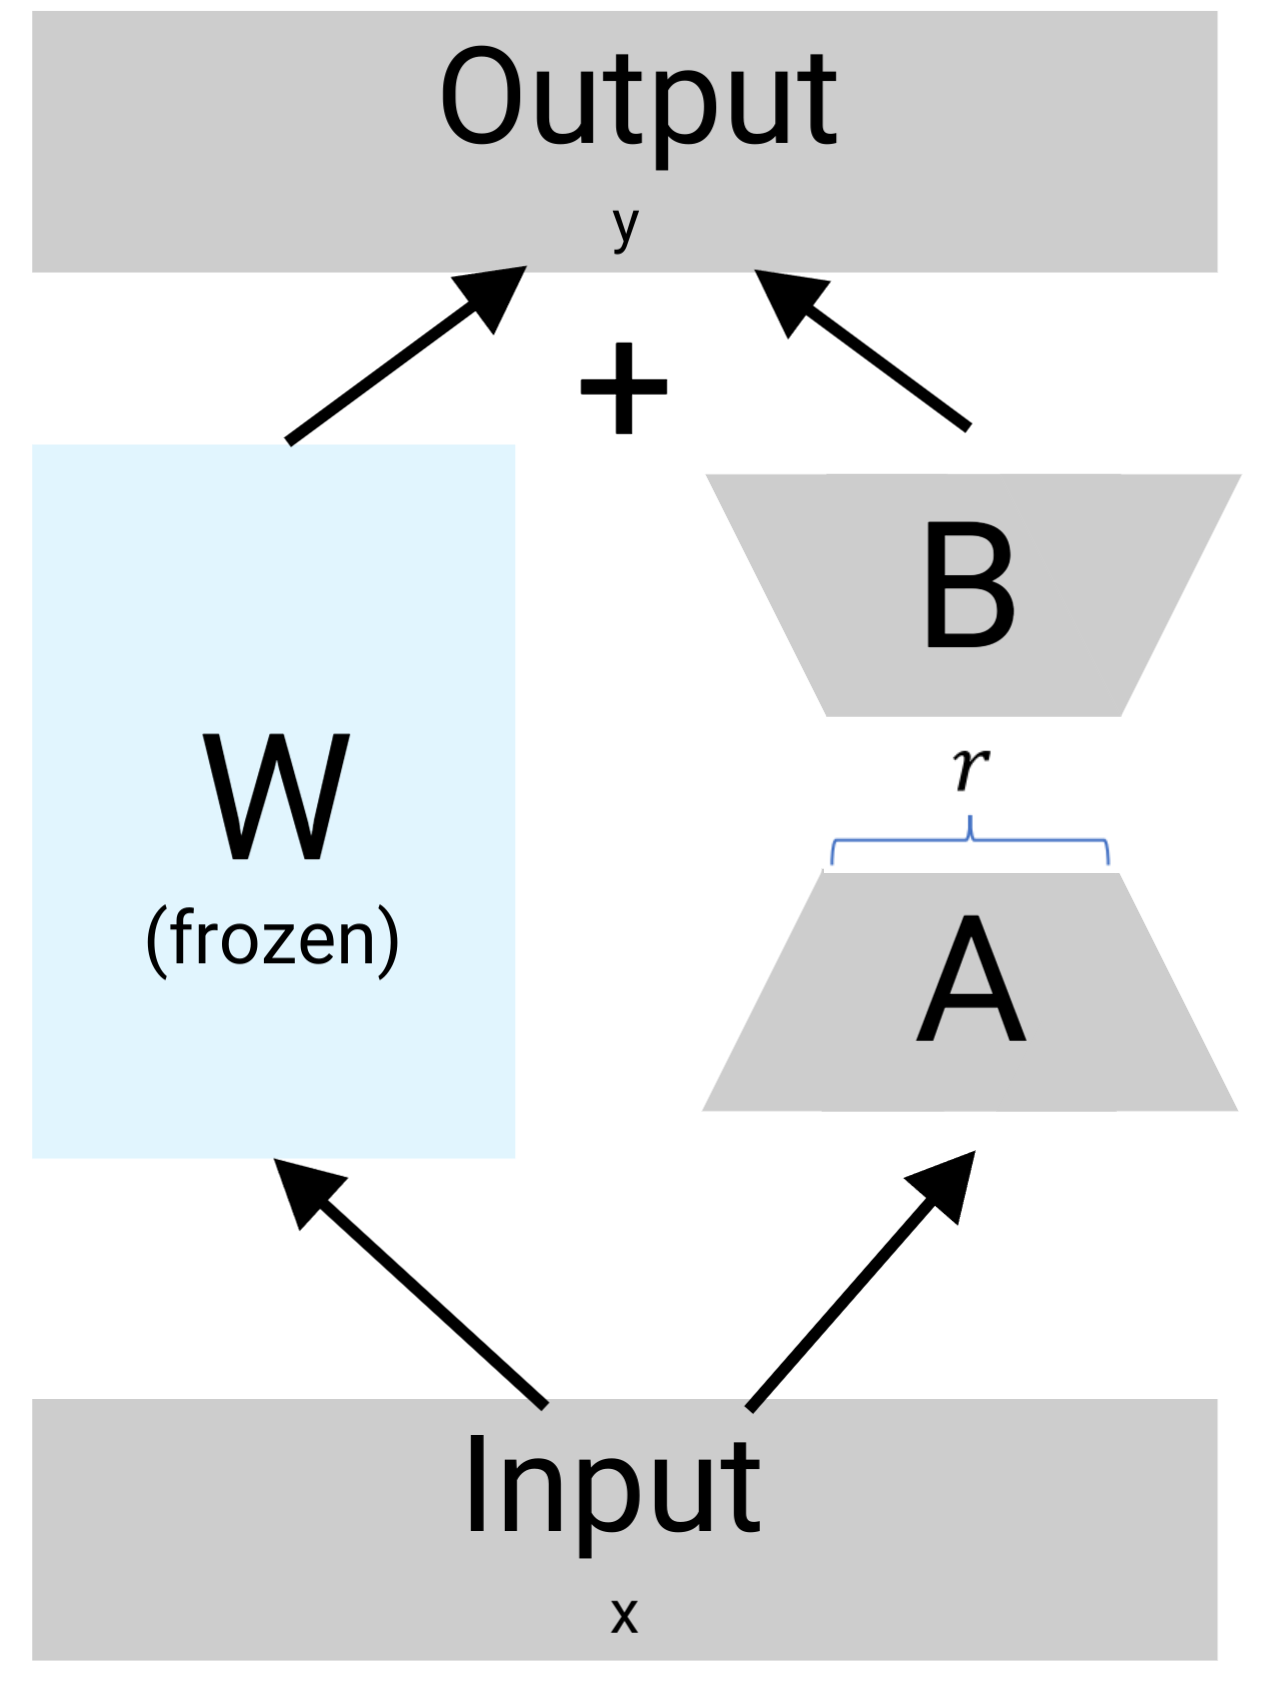



Преимущества LoRA:
+ Задействуем меньше памяти, т.к. обучаются только матрицы A и B
+ Меньше параметров для обновления
+ Применимо к любым линейным слоям
+ Веса можно мержить с базовой моделью
+ Часто* превосходит полную настройку

Основные параметры LoRA:
   - `r` (rank): Размерность низкорангового разложения (обычно 4-64)
   - `lora_alpha`: Коэффициент масштабирования (обычно 2*r)
   - `lora_dropout`: Dropout для предотвращения переобучения
   - `target_modules`: Какие слои адаптировать (обычно query, value, etc.)

# Практика LoRA

In [ ]:
from peft import LoraConfig, get_peft_model

In [ ]:
lora_config = LoraConfig(
    r=16,
    lora_alpha=16,
    target_modules=["c_attn", "c_proj", "attn.c_proj"],  # Какие слои адаптировать
    lora_dropout=0.1,
    bias="none",
    modules_to_save=["classifier"],
    #loss_type=ForCasualLM
)

In [ ]:
model_name = "ai-forever/rugpt3small_based_on_gpt2"
lora_model = get_peft_model(
    AutoModelForCausalLM.from_pretrained(model_name),
    lora_config
)

/usr/local/lib/python3.12/dist-packages/peft/tuners/lora/layer.py:2174: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


In [ ]:
print("\nМодель с LoRA создана:")
lora_model.print_trainable_parameters()

print("\nОбучаемые слои LoRA:")
for name, param in lora_model.named_parameters():
    if param.requires_grad:
        print(f"{name}: {param.shape}")


Модель с LoRA создана:
trainable params: 1,622,016 || all params: 126,853,632 || trainable%: 1.2787

Обучаемые слои LoRA:
base_model.model.transformer.h.0.attn.c_attn.lora_A.default.weight: torch.Size([16, 768])
base_model.model.transformer.h.0.attn.c_attn.lora_B.default.weight: torch.Size([2304, 16])
base_model.model.transformer.h.0.attn.c_proj.lora_A.default.weight: torch.Size([16, 768])
base_model.model.transformer.h.0.attn.c_proj.lora_B.default.weight: torch.Size([768, 16])
base_model.model.transformer.h.0.mlp.c_proj.lora_A.default.weight: torch.Size([16, 3072])
base_model.model.transformer.h.0.mlp.c_proj.lora_B.default.weight: torch.Size([768, 16])
base_model.model.transformer.h.1.attn.c_attn.lora_A.default.weight: torch.Size([16, 768])
base_model.model.transformer.h.1.attn.c_attn.lora_B.default.weight: torch.Size([2304, 16])
base_model.model.transformer.h.1.attn.c_proj.lora_A.default.weight: torch.Size([16, 768])
base_model.model.transformer.h.1.attn.c_proj.lora_B.default.weight

## Загрузка данных

Если вы перезапустили kernel, загрузите данные из задачи выше
( всё вплоть до `data_collator` )

## Обучение незамороженных слоёв

In [ ]:
lora_training_args = TrainingArguments(
    output_dir="./lora_sib200_results",
    overwrite_output_dir=True,
    num_train_epochs=3,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    eval_strategy="steps",
    eval_steps=100,
    logging_steps=50,
    save_steps=200,
    learning_rate=1e-3,           # Меньше LR для LoRA чем для Prompt-Tuning
    warmup_steps=100,
    report_to=None,
    remove_unused_columns=True,
    gradient_accumulation_steps=2,
    dataloader_pin_memory=False,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
)

In [ ]:
# @title
lora_training_args = TrainingArguments(
    output_dir="./lora_sib200_results",
    overwrite_output_dir=True,
    num_train_epochs=1,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    eval_strategy="steps",
    eval_steps=100,
    logging_steps=50,
    save_steps=100,
    learning_rate=3e-2,
    warmup_steps=100,
    report_to=None,
    remove_unused_columns=True,
    gradient_accumulation_steps=2,
    dataloader_pin_memory=False,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
)

In [ ]:
lora_trainer = Trainer(
    model=lora_model,
    args=lora_training_args,
    train_dataset=train_dataset_processed,
    eval_dataset=validation_dataset_processed,
    data_collator=data_collator,
    tokenizer=tokenizer,
)

print(f"Обучаемые параметры: {sum(p.numel() for p in lora_model.parameters() if p.requires_grad):,}")
lora_train_history = lora_trainer.train()

print("Обучение с LoRA завершено!")

/tmp/ipython-input-1566965055.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  lora_trainer = Trainer(


Обучаемые параметры: 1,622,016


Step,Training Loss,Validation Loss


Обучение с LoRA завершено!


## Test

In [ ]:
def predict_with_lora(text, model, tokenizer):
    prompt = f"Классифицируй текст: {text}\nКатегория:"

    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=256)

    model.eval()
    with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=5,
                do_sample=False,
                temperature=0.1,
                pad_token_id=tokenizer.eos_token_id,
                repetition_penalty=1.1,
            )

    generated = tokenizer.decode(outputs[0], skip_special_tokens=True)

    if "Категория:" in generated:
        category_part = generated.split("Категория:")[-1].strip()
        predicted = category_part.split()[0] if category_part.split() else "unknown"
    else:
        predicted = "unknown"

    return predicted, generated

In [ ]:
def test_lora_model():
    test_examples = [
        "В Москве прошла международная научная конференция по искусственному интеллекту",
        "Футбольный матч между локальными командами завершился со счетом 3:0",
        "Курс евро на бирже сегодня показал значительный рост",
        "В национальном музее открылась выставка современного искусства",
    ]

    print("Результаты предсказаний LoRA модели:\n")
    for i, text in enumerate(test_examples, 1):
        predicted, full_output = predict_with_lora(text, lora_model, tokenizer)
        print(f"Пример {i}:")
        print(f"   Текст: {text[:60]}...")
        print(f"   Предсказание: '{predicted}'")
        print(f"   Полный вывод: {full_output}")
        print("-" * 80)

test_lora_model()

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Результаты предсказаний LoRA модели:

Пример 1:
   Текст: В Москве прошла международная научная конференция по искусст...
   Предсказание: 'science/techn'
   Полный вывод: Классифицируй текст: В Москве прошла международная научная конференция по искусственному интеллекту
Категория:science/techn
--------------------------------------------------------------------------------
Пример 2:
   Текст: Футбольный матч между локальными командами завершился со сче...
   Предсказание: 'sciencepolitics'
   Полный вывод: Классифицируй текст: Футбольный матч между локальными командами завершился со счетом 3:0
Категория:sciencepolitics
--------------------------------------------------------------------------------
Пример 3:
   Текст: Курс евро на бирже сегодня показал значительный рост...
   Предсказание: 'science'
   Полный вывод: Классифицируй текст: Курс евро на бирже сегодня показал значительный рост
Категория:science
-------------------------------------------------------------------------------

In [ ]:
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
def evaluate_classification_metrics(model, tokenizer, test_dataset, label2id, id2label, num_samples=None):

    if num_samples is not None:
        test_dataset = test_dataset.select(range(min(num_samples, len(test_dataset))))

    true_categories = []
    predicted_categories = []

    for i, example in enumerate(test_dataset):
        text = example['text']
        true_category = example['category']

        predicted_category, _ = predict_with_lora(text, model, tokenizer)

        true_categories.append(true_category)
        predicted_categories.append(predicted_category)


    true_numeric = [label2id.get(cat, -1) for cat in true_categories]
    predicted_numeric = [label2id.get(cat, -1) for cat in predicted_categories]

    unknown_pred = sum(1 for x in predicted_numeric if x == -1)

    if unknown_pred > 0:
        print(f"⚠️  Предупреждение: {unknown_pred} предсказанных категорий не найдены в label2id")
        print(set(predicted_categories))

    valid_indices = [i for i, (t, p) in enumerate(zip(true_numeric, predicted_numeric)) if t != -1 and p != -1]
    true_filtered = [true_numeric[i] for i in valid_indices]
    pred_filtered = [predicted_numeric[i] for i in valid_indices]
    true_categories_filtered = [true_categories[i] for i in valid_indices]
    pred_categories_filtered = [predicted_categories[i] for i in valid_indices]


    print(classification_report(true_categories_filtered, pred_categories_filtered,
                              labels=list_of_categories, zero_division=0))


metrics = evaluate_classification_metrics(lora_model, tokenizer, test_set, label2id, id2label, num_samples=200)

⚠️  Предупреждение: 198 предсказанных категорий не найдены в label2id
{'sciencepolitics', 'sportsportsportsportsport', 'screamsports', 'sleepsport', 'sportssportsportsport', 'sleep', 'science/tech', 'science', 'science/techn', 'sports', 'sentertainment', 'scalasport', 'sciences', 'sciencesports', 'schealth'}
                    precision    recall  f1-score   support

     entertainment       0.00      0.00      0.00         0
         geography       0.00      0.00      0.00         0
            health       0.00      0.00      0.00         0
          politics       0.00      0.00      0.00         0
science/technology       0.00      0.00      0.00         0
            sports       1.00      1.00      1.00         2
            travel       0.00      0.00      0.00         0

          accuracy                           1.00         2
         macro avg       0.14      0.14      0.14         2
      weighted avg       1.00      1.00      1.00         2



## * Задание под звёздочкой:

Можно улучшить качество генерируемых категорий за счет двухэтапной проверки сгенерированных ответов.

In [ ]:
import random

In [ ]:
def predict_with_validation(model, tokenizer, text, valid_categories, max_new_tokens=3):
    """
    Предсказание с валидацией что категория существует в списке
    """
    prompt = f"Классифицируй текст: {text}\nКатегория:"

    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=256)

    model.eval()
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            do_sample=False,
            temperature=0.1,
            pad_token_id=tokenizer.eos_token_id,
            repetition_penalty=1.1,
            num_return_sequences=1,
        )

    generated = tokenizer.decode(outputs[0], skip_special_tokens=True)

    if "Категория:" in generated:
        category_part = generated.split("Категория:")[-1].strip()
        raw_prediction = category_part.split()[0] if category_part.split() else "unknown"
        cleaned_prediction = raw_prediction.rstrip('.,; \n')

        # ВАЛИДАЦИЯ: проверяем есть ли категория в списке
        # Ищем наиболее похожую категорию
        for valid_cat in valid_categories:
            if cleaned_prediction.startswith(valid_cat) or valid_cat.startswith(cleaned_prediction):
                return valid_cat, generated

        # Если точного совпадения нет, ищем по префиксу
        for valid_cat in valid_categories:
            if cleaned_prediction.lower().startswith(valid_cat.lower()[:3]):
                return valid_cat, generated

        # Если ничего не нашли, возвращаем наиболее частую категорию
        return valid_categories[0], generated
    else:
        return valid_categories[0], generated

test_dataset = test_set.select(random.sample(range(1, len(test_set)), 5))
for text in test_dataset:
    predicted, full_output = predict_with_validation(lora_model, tokenizer, text['text'], list_of_categories)
    print(f"Текст: {text}")
    print(f"Предсказание: '{predicted}'")
    print(f"Полный вывод: {full_output}")
    print("-" * 50)

Текст: {'index_id': 927, 'category': 'science/technology', 'text': 'Запускать дрона около аэропорта или над толпой людей – это почти всегда плохая идея, даже если там, где вы живете, это не запрещено законом.'}
Предсказание: 'science/technology'
Полный вывод: Классифицируй текст: Запускать дрона около аэропорта или над толпой людей – это почти всегда плохая идея, даже если там, где вы живете, это не запрещено законом.
Категория:science
--------------------------------------------------
Текст: {'index_id': 1583, 'category': 'health', 'text': 'Рассеянный склероз – это заболевание, поражающее центральную нервную систему, которая состоит из головного мозга, спинного мозга и зрительного нерва.'}
Предсказание: 'science/technology'
Полный вывод: Классифицируй текст: Рассеянный склероз – это заболевание, поражающее центральную нервную систему, которая состоит из головного мозга, спинного мозга и зрительного нерва.
Категория:science/
--------------------------------------------------
Текст: {'i

In [ ]:
metrics = evaluate_classification_metrics(lora_model, tokenizer, test_set, label2id, id2label, num_samples=200)

                    precision    recall  f1-score   support

     entertainment       0.17      0.05      0.08        19
         geography       0.00      0.00      0.00        13
            health       0.00      0.00      0.00        22
          politics       0.00      0.00      0.00        30
science/technology       0.27      1.00      0.43        51
            sports       1.00      0.24      0.39        25
            travel       0.00      0.00      0.00        40

          accuracy                           0.29       200
         macro avg       0.21      0.18      0.13       200
      weighted avg       0.21      0.29      0.16       200



# Итог

In [ ]:
def compare_peft_methods():
    print("Сравнение методов\n")

    methods_comparison = {
        "Аспект": ["Принцип работы", "Обучаемые параметры", "Качество", "Скорость", "Память", "Применение"],
        "Prompt-Tuning": [
            "Добавляет виртуальные токены в embedding",
            "Только embedding виртуальных токенов",
            "Хорошее (зависит от промптов)",
            "Очень быстрая",
            "Минимальная",
            "Текстовая классификация, простые задачи"
        ],
        "LoRA": [
            "Низкоранговое разложение матриц весов",
            "Матрицы A и B в выбранных слоях",
            "Отличное (близко к full fine-tuning)",
            "Быстрая",
            "Низкая",
            "Любые задачи, сложные домены"
        ]
    }

    print(f"{'Аспект':<20} {'Prompt-Tuning':<40} {'LoRA':<40}")
    print("-" * 80)
    for i in range(len(methods_comparison["Аспект"])):
        aspect = methods_comparison["Аспект"][i]
        prompt_tuning = methods_comparison["Prompt-Tuning"][i]
        lora = methods_comparison["LoRA"][i]
        print(f"{aspect:<20} {prompt_tuning:<40} {lora:<40}")

compare_peft_methods()

Сравнение методов

Аспект               Prompt-Tuning                            LoRA                                    
--------------------------------------------------------------------------------
Принцип работы       Добавляет виртуальные токены в embedding Низкоранговое разложение матриц весов   
Обучаемые параметры  Только embedding виртуальных токенов     Матрицы A и B в выбранных слоях         
Качество             Хорошее (зависит от промптов)            Отличное (близко к full fine-tuning)    
Скорость             Очень быстрая                            Быстрая                                 
Память               Минимальная                              Низкая                                  
Применение           Текстовая классификация, простые задачи  Любые задачи, сложные домены            
